[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=0,
)

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field


class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

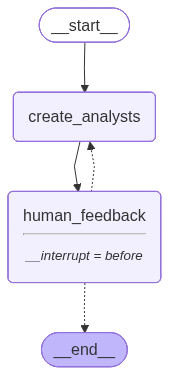

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import time


analyst_instructions="""You are tasked with creating a set of AI analyst personas. 
Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""


def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state.get('max_analysts', 1)
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback, 
        max_analysts=max_analysts
        )

    # Generate question 
    analysts = structured_llm.invoke(
        [
            SystemMessage(content=system_message)
        ]+[
            HumanMessage(content="Generate the set of analysts.")
        ]
    )
    time.sleep(10)
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(
    {"topic":topic,"max_analysts":max_analysts,}, 
    thread, 
    stream_mode="values"
    ):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Anya Sharma
Affiliation: CognitiveFlow Solutions
Role: AI Workflow Architect
Description: Focuses on the strategic design and optimization of multi-agent systems. Concerned with how LangGraph streamlines complex decision-making processes and task handoffs between autonomous agents, ensuring robust and efficient operational flows. Motivated by achieving seamless, intelligent automation.
--------------------------------------------------
Name: Ben Carter
Affiliation: DevOps AI Guild
Role: Senior AI Developer Advocate
Description: Specializes in developer experience and productivity for AI engineers. Interested in how LangGraph's structured approach and tooling reduce development time, simplify debugging, and lower the barrier to entry for building sophisticated agentic applications. Motivated by empowering developers to build faster and more reliably.
--------------------------------------------------
Name: Dr. Lena Petrova
Affiliation: QuantumScale AI Labs
Role: AI Systems Per

In [8]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [9]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0c5cd8-d911-6ddc-8002-526469a56992'}}

In [10]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Anya Sharma
Affiliation: CognitiveFlow Solutions
Role: AI Workflow Architect
Description: Focuses on the strategic design and optimization of multi-agent systems. Concerned with how LangGraph streamlines complex decision-making processes and task handoffs between autonomous agents, ensuring robust and efficient operational flows. Motivated by achieving seamless, intelligent automation.
--------------------------------------------------
Name: Ben Carter
Affiliation: DevOps AI Guild
Role: Senior AI Developer Advocate
Description: Specializes in developer experience and productivity for AI engineers. Interested in how LangGraph's structured approach and tooling reduce development time, simplify debugging, and lower the barrier to entry for building sophisticated agentic applications. Motivated by empowering developers to build faster and more reliably.
--------------------------------------------------
Name: Dr. Lena Petrova
Affiliation: QuantumScale AI Labs
Role: AI Systems Per

In [11]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0c5cdb-e451-69dd-8004-6b734416059e'}}

In [12]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [13]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [17]:
graph.get_state(thread)

StateSnapshot(values={'topic': 'The benefits of adopting LangGraph as an agent framework', 'max_analysts': 3, 'human_analyst_feedback': None, 'analysts': [Analyst(affiliation='Large Tech Company', name='Dr. Evelyn Reed', role='Principal AI Architect', description='Focuses on the technical robustness, scalability, and integration challenges of LangGraph within existing enterprise systems. Concerned with performance, maintainability, and developer adoption across large teams.'), Analyst(affiliation='AI Consulting Firm', name='Mr. Alex Chen', role='Head of AI Strategy', description='Examines the strategic advantages and business value of LangGraph, including its impact on development cycles, operational efficiency, and competitive differentiation for clients. Interested in ROI and long-term strategic fit.'), Analyst(affiliation='AI Startup', name='Ms. Maya Singh', role='CTO & Co-founder', description='Evaluates LangGraph from an entrepreneurial perspective, focusing on rapid prototyping, 

In [ ]:
# state history is like Stack, Oldest State is the at last index
[s for s in graph.get_state_history(thread)]

[StateSnapshot(values={'topic': 'The benefits of adopting LangGraph as an agent framework', 'max_analysts': 3, 'human_analyst_feedback': None, 'analysts': [Analyst(affiliation='Large Tech Company', name='Dr. Evelyn Reed', role='Principal AI Architect', description='Focuses on the technical robustness, scalability, and integration challenges of LangGraph within existing enterprise systems. Concerned with performance, maintainability, and developer adoption across large teams.'), Analyst(affiliation='AI Consulting Firm', name='Mr. Alex Chen', role='Head of AI Strategy', description='Examines the strategic advantages and business value of LangGraph, including its impact on development cycles, operational efficiency, and competitive differentiation for clients. Interested in ROI and long-term strategic fit.'), Analyst(affiliation='AI Startup', name='Ms. Maya Singh', role='CTO & Co-founder', description='Evaluates LangGraph from an entrepreneurial perspective, focusing on rapid prototyping,

In [20]:
final_state.next

()

In [21]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Evelyn Reed
Affiliation: Large Tech Company
Role: Principal AI Architect
Description: Focuses on the technical robustness, scalability, and integration challenges of LangGraph within existing enterprise systems. Concerned with performance, maintainability, and developer adoption across large teams.
--------------------------------------------------
Name: Mr. Alex Chen
Affiliation: AI Consulting Firm
Role: Head of AI Strategy
Description: Examines the strategic advantages and business value of LangGraph, including its impact on development cycles, operational efficiency, and competitive differentiation for clients. Interested in ROI and long-term strategic fit.
--------------------------------------------------
Name: Ms. Maya Singh
Affiliation: AI Startup
Role: CTO & Co-founder
Description: Evaluates LangGraph from an entrepreneurial perspective, focusing on rapid prototyping, resource efficiency, time-to-market, and how it enables innovative agentic solutions for startups wit

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [6]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [7]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
    time.sleep(10)    
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://docs.langchain.com/oss/python/integrations/document_loaders/web_base)
* Indexed documents e.g., via [RAG](https://docs.langchain.com/oss/python/langchain/retrieval)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [8]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [9]:
# Web search tool
from langchain_tavily import TavilySearch  # updated 1.0

tavily_search = TavilySearch(max_results=3)

In [10]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

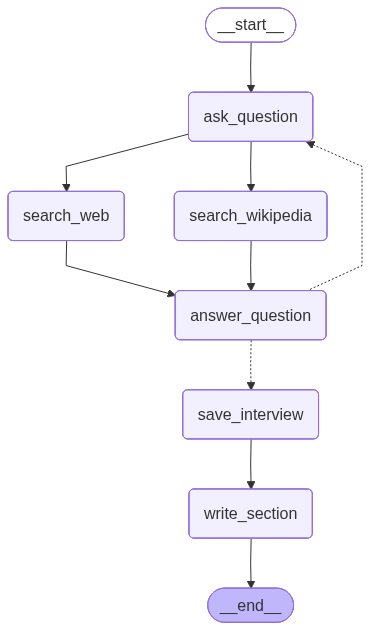

In [11]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    time.sleep(10)
    # Search
    #search_docs = tavily_search.invoke(search_query.search_query) # updated 1.0
    data = tavily_search.invoke({"query": search_query.search_query})
    search_docs = data.get("results", data)
    

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    time.sleep(10)
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
    time.sleep(10)    
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
    time.sleep(10)        
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [34]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Large Tech Company', name='Dr. Evelyn Reed', role='Principal AI Architect', description='Focuses on the technical robustness, scalability, and integration challenges of LangGraph within existing enterprise systems. Concerned with performance, maintainability, and developer adoption across large teams.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [35]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## LangGraph in the Enterprise: Architecting Robust, Scalable, and Maintainable AI Systems

### Summary
As enterprises increasingly deploy sophisticated AI solutions that demand more than simple prompt-response interactions, the need for robust orchestration frameworks becomes paramount. LangGraph emerges as a powerful evolution in this landscape, specifically designed to address the complexities of multi-agent systems and stateful processing within enterprise environments.

Unlike traditional linear chain-based approaches, such as those found in earlier iterations of LangChain, LangGraph introduces a graph-based architecture that fundamentally changes how AI workflows are designed and managed [3, 6]. This novel approach allows for the creation of state machines with persistent memory, complex decision trees, and dynamic control flow, enabling AI agents to revisit previous steps, adapt to changing conditions, and maintain context across extended interactions [1, 2]. This directly contributes to the technical robustness required for production-grade AI systems, moving beyond rapid prototyping to handle complex real-world requirements [3].

Key strengths of LangGraph for enterprise adoption include its enhanced context management, flexible workflow design with conditional branching, and seamless integration of human-in-the-loop components [1, 4]. These capabilities are crucial for building high-performing, scalable AI agents for use cases like customer experience automation, compliance monitoring, and dynamic decision support systems [2, 6]. The framework's ability to clearly visualize workflow logic through its graph structure also significantly aids maintainability and debugging, offering transparency at each step of execution [1, 4, 6].

However, the adoption of LangGraph within large enterprise teams presents specific integration and developer adoption considerations. While built on top of LangChain, LangGraph demands a more sophisticated skill set, requiring an understanding of graph theory, state management, and advanced software architecture patterns [3]. This contrasts with LangChain's focus on chain composition and prompt engineering, suggesting that organizations may need to invest in training or specialized expertise to fully leverage LangGraph's capabilities and ensure smooth developer adoption across large teams [2, 3]. Despite this, its flexibility, reliability, and control make it an ideal choice for enterprises focused on building truly sophisticated, production-grade AI systems [3, 6].

### Sources
[1] https://www.royalcyber.com/blogs/ai-ml/langgraph-multi-agent-workflows-enterprise-ai/
[2] https://blog.agen.cy/p/agency-revolutionizing-ai-development
[3] https://thirdeyedata.ai/a-comparative-study-between-langgraph-and-langchain-for-enterprise-ai-development/
[4] https://www.ai21.com/knowledge/ai-agent-frameworks/
[5] https://galileo.ai/blog/autogen-vs-crewai-vs-langgraph-vs-openai-agents-framework
[6] https://www.ema.co/additional-blogs/addition-blogs/building-ai-agents-langgraph

In [37]:
print(interview['sections'][0])

## LangGraph in the Enterprise: Architecting Robust, Scalable, and Maintainable AI Systems

### Summary
As enterprises increasingly deploy sophisticated AI solutions that demand more than simple prompt-response interactions, the need for robust orchestration frameworks becomes paramount. LangGraph emerges as a powerful evolution in this landscape, specifically designed to address the complexities of multi-agent systems and stateful processing within enterprise environments.

Unlike traditional linear chain-based approaches, such as those found in earlier iterations of LangChain, LangGraph introduces a graph-based architecture that fundamentally changes how AI workflows are designed and managed [3, 6]. This novel approach allows for the creation of state machines with persistent memory, complex decision trees, and dynamic control flow, enabling AI agents to revisit previous steps, adapt to changing conditions, and maintain context across extended interactions [1, 2]. This directly contr

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [12]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

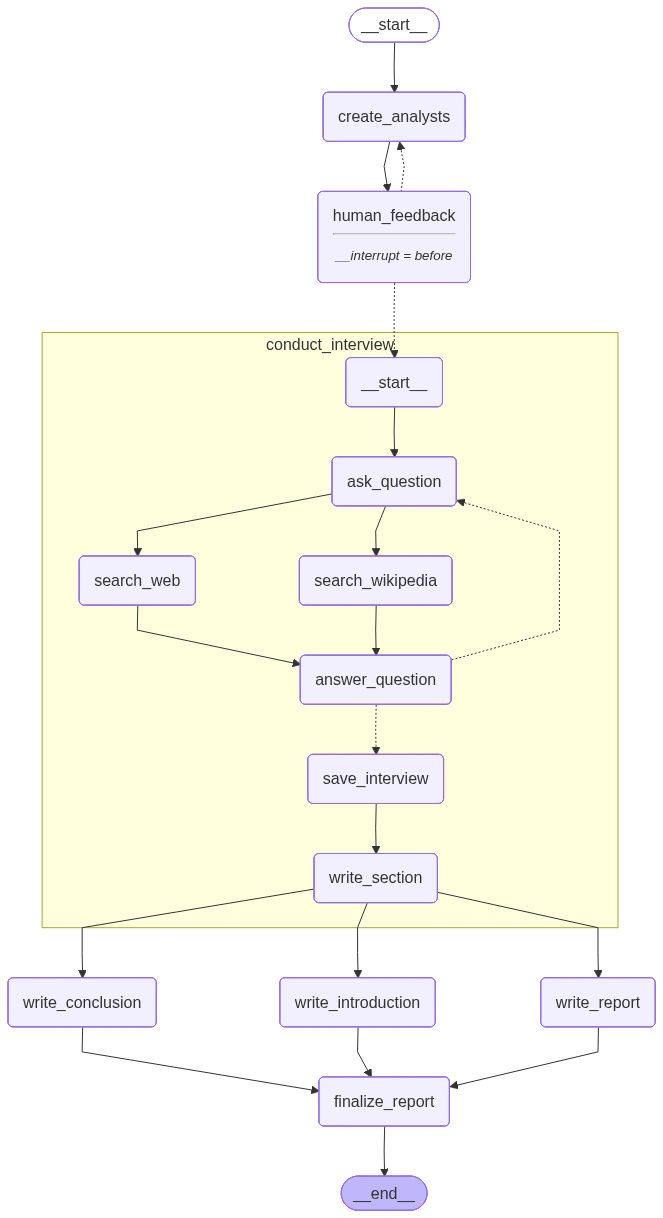

In [13]:
from langgraph.types import Send # updated in 1.0


def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [
            Send(
                node="conduct_interview", 
                arg={
                    "analyst": analyst,
                    "messages": [
                        HumanMessage(content=f"So you said you were writing an article on {topic}?")
                        ]
                    }
                ) for analyst in state["analysts"]
            ]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    time.sleep(10)
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(
        topic=topic, 
        formatted_str_sections=formatted_str_sections
        )    
    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    time.sleep(10)

    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    time.sleep(10)

    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [14]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                           thread, 
                           stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Anya Sharma
Affiliation: Synapse AI Labs
Role: Principal AI Architect
Description: Focuses on the underlying technical architecture and performance implications of agent frameworks. Concerned with system stability, scalability, and the ability to manage complex, stateful AI workflows efficiently. Seeks to understand how LangGraph enhances the robustness and reliability of AI systems.
--------------------------------------------------
Name: Maya Chen
Affiliation: Innovate AI Solutions
Role: Lead AI Engineer
Description: Specializes in developer productivity and rapid prototyping of AI applications. Interested in how LangGraph streamlines the development process, reduces time-to-market for new agentic features, and fosters iterative innovation within engineering teams. Values frameworks that simplify complexity and accelerate experimentation.
--------------------------------------------------
Name: David Miller
Affiliation: Quantum Insights Group
Role: AI Strategy Consultant
De

In [15]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0c5e5b-04ba-67f7-8002-b0a54e1a63f6'}}

In [16]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Anya Sharma
Affiliation: Synapse AI Labs
Role: Principal AI Architect
Description: Focuses on the underlying technical architecture and performance implications of agent frameworks. Concerned with system stability, scalability, and the ability to manage complex, stateful AI workflows efficiently. Seeks to understand how LangGraph enhances the robustness and reliability of AI systems.
--------------------------------------------------
Name: Maya Chen
Affiliation: Innovate AI Solutions
Role: Lead AI Engineer
Description: Specializes in developer productivity and rapid prototyping of AI applications. Interested in how LangGraph streamlines the development process, reduces time-to-market for new agentic features, and fosters iterative innovation within engineering teams. Values frameworks that simplify complexity and accelerate experimentation.
--------------------------------------------------
Name: David Miller
Affiliation: Quantum Insights Group
Role: AI Strategy Consultant
De

In [17]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0c5e5b-b07e-6622-8004-f8189588b9f0'}}

In [18]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 2.72393582s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10


--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [19]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Revolutionizing AI Agent Development with LangGraph

## Introduction
The promise of advanced AI agents often clashes with the complexities of development, control, and reliability. This report explores LangGraph, a transformative framework built on LangChain, that addresses these challenges head-on. We will first examine how LangGraph's graph-based approach unlocks advanced AI capabilities, driving product innovation through enhanced reasoning, state management, and multi-agent systems. Next, we delve into its technical advantages, highlighting stateful applications, granular workflow control, and superior debugging. Finally, we assess LangGraph's operational edge, showcasing its robust deployment, real-time monitoring, and proven scalability in demanding production environments.

---



The rapid evolution of artificial intelligence, particularly in generative AI and machine learning, promises significant productivity gains across industries, from enhancing contact center efficiency by up to 15% to accelerating writing tasks by 40% [4, 5]. However, developing robust, enterprise-grade AI agents often encounters challenges related to complexity, control, and reliability, moving beyond the limitations of traditional linear programming and simple prompt-completion methods [1, 2, 4, 6]. LangGraph emerges as a pivotal framework addressing these hurdles, offering a novel approach to AI agent development that fundamentally shifts agent design from sequential chains to sophisticated graph-based workflows.

Built upon the LangChain ecosystem, LangGraph empowers developers to construct AI workflows as directed cyclic graphs, enabling sophisticated logic, intricate conditional branching, and loops [1, 2, 6]. This graphical paradigm provides enhanced control over execution flow, making it ideal for complex, real-world applications and ensuring more consistent results with fewer logical errors [2, 7]. By explicitly modeling reasoning processes as distinct states with well-defined transitions, LangGraph significantly speeds up development and reduces debugging efforts, even as AI-assisted coding can sometimes introduce "workslop" [4, 6].

A key innovation of LangGraph is its emphasis on stateful, multi-agent applications, allowing agents to remember past actions and maintain persistent memory, which is crucial for real-world applications where context and history are vital [1, 5]. Without proper state management, an AI agent risks being merely an "expensive API call" rather than a truly intelligent system [5]. LangGraph facilitates this by enabling multiple agents to share state through common channels and supports advanced coordination mechanisms such as human-in-the-loop patterns for critical decision points, map-reduce workflows for parallel agent coordination, and consensus mechanisms for multi-agent agreement [4, 5]. This structured, graph-based approach facilitates the design of agents with enhanced reasoning capabilities, persistent memory, and robust state management [3, 6].

Furthermore, LangGraph provides features that contribute to enhanced debugging and reliability. It allows for the tracking of state transitions, memory usage patterns, and decision paths, which are invaluable for understanding agent behavior and identifying issues [5]. The framework also includes production-ready features like monitoring and observability, node caching, deferred nodes, and hooks, streamlining development and deployment [4]. The General Availability (GA) of LangGraph Platform specifically simplifies the deployment of complex AI agents requiring persistent state management across sessions, integrating optimized checkpointers and memory stores to eliminate the need for custom solutions [2].

For ongoing operational oversight, LangGraph Platform now provides real-time deployment metrics directly within the LangSmith UI, including vital statistics such as CPU and memory usage, API request latency, and the count of pending or active runs [1]. This "enterprise-grade observability" offers robust tracing capabilities and structured logging, crucial for following execution paths, monitoring health, and enabling faster troubleshooting and proactive performance management in production multi-agent deployments [1, 5]. From a scalability and robustness perspective, LangGraph's graph-based architecture is particularly well-suited for advanced workflow management, including conditional branching, parallel processing, and handling intricate inter-agent dependencies [6]. This design provides a robust framework for deploying distributed agents and maintaining state consistency, demonstrating impressive performance with agents achieving sub-second responses for simple queries and significant speed improvements, such as 75% faster for cached queries [3, 6]. Leading companies like LinkedIn, Uber, Klarna, and Elastic are already leveraging LangGraph for their production AI agent systems, underscoring its proven capability in demanding operational contexts [2, 4]. LangGraph offers the flexibility, reliability, and control needed to meet enterprise demands, providing a robust and scalable foundation for future AI initiatives and enabling developers to build high-performing AI agents that can differentiate products in a competitive market [2, 3, 7, 8].


---

## Conclusion
LangGraph emerges as a pivotal framework, fundamentally transforming AI agent development by addressing the complexities of building robust, enterprise-grade systems. It leverages a graph-based approach to enable sophisticated logic, state management, and multi-agent coordination, significantly enhancing reasoning and reliability. Technically, LangGraph provides unparalleled control over workflows, persistent memory for stateful applications, and advanced debugging capabilities, ensuring agents are intelligent and adaptable. Operationally, the LangGraph Platform simplifies deployment, offers critical real-time monitoring and observability, and ensures scalability and robustness for production environments, as evidenced by its adoption by leading companies. Adopting LangGraph empowers organizations to unlock advanced AI capabilities, drive innovation, and achieve market leadership.

## Sources
1. https://aankitroy.com/blog/langgraph-state-management-memory-guide
2. https://blog.langchain.com/why-langgraph-platform/
3. https://changelog.langchain.com/announcements/view-deployment-metrics-in-langgraph-platform
4. https://community.latenode.com/t/what-are-the-main-advantages-of-choosing-langgraph-for-ai-agent-development/31000
5. https://www.designveloper.com/blog/what-is-langgraph/
6. https://www.ema.co/additional-blogs/addition-blogs/building-ai-agents-langgraph
7. https://en.wikipedia.org/wiki/Applications_of_artificial_intelligence
8. https://en.wikipedia.org/wiki/Deep_learning
9. https://interviewkickstart.com/blogs/articles/langgraph-for-retail-ai-agent
10. https://jetthoughts.com/blog/langgraph-workflows-state-machines-ai-agents/
11. https://www.langchain.com/langgraph
12. https://latenode.com/blog/ai-frameworks-technical-infrastructure/langgraph-multi-agent-orchestration/langgraph-multi-agent-orchestration-complete-framework-guide-architecture-analysis-2025
13. https://www.linkedin.com/posts/om-manoj-sharma-b87b22291_when-i-first-explored-ai-agent-frameworks-activity-7386795010488401920-THol
14. https://medium.com/@jalajagr/evaluating-langgraph-framework-series-8-enterprise-grade-observability-bc5531c11bb2
15. https://www.reddit.com/r/AI_Agents/comments/1l4uq7v/why_use_langgraph/
16. https://www.reddit.com/r/LangChain/comments/1g1pkki/openais_new_framework_for_agents_why_is_langgraph/
17. https://www.royalcyber.com/blogs/ai-ml/build-ai-agents-langgraph-langchain/

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r